In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# Read data into pandas
japan = pd.read_excel(".././data/Price History_EWJ_Japan_Equity.xlsx")
t_bills_7_10 = pd.read_excel(".././data/Price History_7-10_US_TBills.xlsx")
t_bills_20 = pd.read_excel(".././data/Price History_20+_US_TBills.xlsx")
apac_x_japan = pd.read_excel(".././data/Price History_EPP_APACxJapan_Equity.xlsx")
europe = pd.read_excel(".././data/Price History_IEV_Europe_Equity.xlsx")
latam = pd.read_excel(".././data/Price History_ILF_LatAm_Equity.xlsx")
us = pd.read_excel(".././data/Price History_IVV_US_Equity.xlsx")
gold = pd.read_excel(".././data/Price History_IAU_Gold_Trust.xlsx")

In [3]:
def preprocess_and_rename(df, name):
    df['Exchange Date'] = pd.to_datetime(df['Exchange Date'])
    df.set_index('Exchange Date', inplace=True)
    df.rename(columns={'%Chg':f'Return {name}'}, inplace=True)
    return df[[f'Return {name}']]

# Preprocess all datasets and rename columns
japan = preprocess_and_rename(japan, 'Japan')
t_bills_7_10 = preprocess_and_rename(t_bills_7_10, 'T-Bills_7_10')
t_bills_20 = preprocess_and_rename(t_bills_20, 'T-Bills_20')
apac_x_japan = preprocess_and_rename(apac_x_japan, 'APACxJapan')
europe = preprocess_and_rename(europe, 'Europe')
latam = preprocess_and_rename(latam, 'LatAm')
us = preprocess_and_rename(us, 'US')
gold = preprocess_and_rename(gold, 'Gold')

In [4]:
us

,Return US
Exchange Date,
2024-12-13,-0.000181
2024-12-12,-0.005306
2024-12-11,0.007707
2024-12-10,-0.002896
2024-12-09,-0.005157
...,...
2005-01-07,-0.001852
2005-01-06,0.004058
2005-01-05,-0.006050


In [5]:
# Merge all datasets on 'Exchange Date'
returns = japan.join([t_bills_7_10, t_bills_20, apac_x_japan, europe, latam, us, gold], how='inner')

# Rename the columns for clarity
returns.columns = ['Japan', 'T-Bills_7_10', 'T-Bills_20', 
                'APACxJapan','Europe','LatAm', 'US', 'Gold']
returns = returns.dropna()
returns = returns.sort_values(by='Exchange Date', ascending=True)

In [6]:
start_date = '2017-06-30'
end_date = '2020-01-31'
returns = returns[start_date:end_date]
returns

,Japan,T-Bills_7_10,T-Bills_20,APACxJapan,Europe,LatAm,US,Gold
Exchange Date,,,,,,,,
2017-06-30,-0.005626,-0.002624,-0.004301,-0.013366,-0.005977,0.007270,0.001564,-0.001672
2017-07-03,-0.006983,-0.003527,-0.004073,-0.007600,0.007972,0.006339,0.001890,-0.017588
2017-07-05,0.003669,0.001084,0.002019,0.001023,-0.005160,-0.000540,0.002132,0.005115
2017-07-06,-0.001729,-0.002546,-0.008576,-0.000740,0.000227,-0.008154,-0.009002,-0.001696
2017-07-07,-0.011943,-0.001522,-0.005573,-0.003559,-0.001993,0.004138,0.006276,-0.010195
...,...,...,...,...,...,...,...,...
2020-01-27,-0.011033,0.005906,0.013467,-0.007243,-0.023740,-0.036351,-0.016231,0.007324
2020-01-28,-0.008328,-0.002631,-0.007263,-0.010863,0.007197,0.016810,0.010650,-0.009253
2020-01-29,0.004750,0.003633,0.008196,-0.006098,0.003929,-0.008754,-0.000701,0.004670


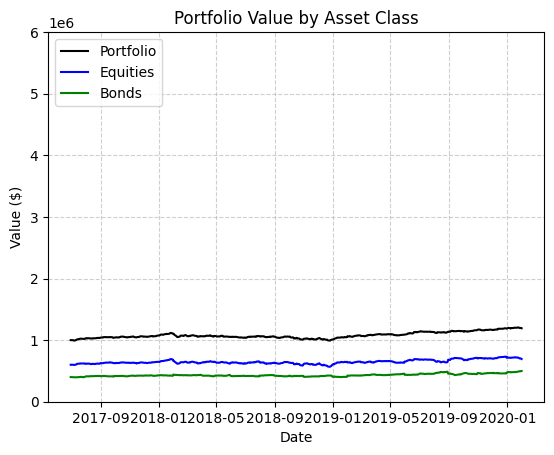

Final Portfolio Value: $1,192,461.07


In [7]:
#### 60E/40B Portfolio Construction #### v3.0

# Parameters
rebalance_on = True       # Switch for rebalancing
initial_inv = 1_000_000
n_freq = 'ME'             # 'ME' = monthly, 'QE' = quarterly, 'YE' = yearly
tc_rate = 0.001           # Transaction cost rate (0 for pure buy & hold)

# Individual asset weights (for a 1/n portfolio across 8 assets)
weights = {
    'Japan': 0.12,
    'APACxJapan': 0.12,
    'Europe': 0.12,
    'LatAm': 0.12,
    'US': 0.12,
    'T-Bills_7_10': 1/5,
    'T-Bills_20': 1/5,
    'Gold': 0,
}
assets = list(weights.keys())

# Determine rebalancing dates (aligned to trading days) if rebalancing is on;
# otherwise, use only the start and end dates.
if rebalance_on:
    reb_dates = returns.resample(n_freq).last().index
    reb_dates = returns.index[returns.index.get_indexer(reb_dates, method='nearest')]
else:
    reb_dates = [returns.index[0], returns.index[-1]]

# Initialize series for overall portfolio value and individual asset values.
port_val = pd.Series(index=returns.index, dtype=float)
port_val.iloc[0] = initial_inv
asset_vals = {asset: pd.Series(index=returns.index, dtype=float) for asset in assets}
for asset in assets:
    asset_vals[asset].iloc[0] = initial_inv * weights[asset]

# Series to record transaction costs and turnover (only used if rebalancing)
tx_costs = pd.Series(0.0, index=returns.index)
turnover_series = pd.Series(0.0, index=returns.index)

if rebalance_on:
    # Loop over each rebalancing period defined by reb_dates.
    for i, reb_date in enumerate(reb_dates):
        prev_date = returns.index[0] if i == 0 else reb_dates[i - 1]
        period = port_val.loc[prev_date:reb_date].index

        # Update asset values day-by-day over this period.
        for t in period[1:]:
            for asset in assets:
                prev = period[period.get_loc(t) - 1]
                asset_vals[asset].loc[t] = asset_vals[asset].loc[prev] * (1 + returns[asset].loc[t])
            port_val.loc[t] = sum(asset_vals[a].loc[t] for a in assets)

        # At the end of the period, if not at the very end, rebalance.
        if i < len(reb_dates) - 1:
            total = port_val.loc[reb_date]
            # Desired target for each asset based on initial weights.
            target_vals = {asset: total * weights[asset] for asset in assets}
            # Compute the absolute trade required (in $ terms) for each asset.
            trades = {asset: abs(target_vals[asset] - asset_vals[asset].loc[reb_date]) for asset in assets}
            total_traded = sum(trades.values())
            turnover = total_traded / total  # (Divide by 2 if using the conventional definition)
            cost = tc_rate * total_traded

            tx_costs.loc[reb_date] = cost
            turnover_series.loc[reb_date] = turnover

            total_adj = total - cost  # Adjusted portfolio value after cost.
            # Reset each asset’s value to the target allocation (using the adjusted total).
            for asset in assets:
                asset_vals[asset].loc[reb_date] = total_adj * weights[asset]
            port_val.loc[reb_date] = total_adj
else:
    # For true buy & hold, update continuously over all trading days.
    for t in returns.index[1:]:
        for asset in assets:
            prev = returns.index[returns.index.get_loc(t) - 1]
            asset_vals[asset].loc[t] = asset_vals[asset].loc[prev] * (1 + returns[asset].loc[t])
        port_val.loc[t] = sum(asset_vals[a].loc[t] for a in assets)

# Forward-fill any missing values.
port_val.ffill(inplace=True)
df_assets = pd.DataFrame(asset_vals)
df_portfolio = pd.concat([port_val, df_assets], axis=1)
df_portfolio.columns = ['Portfolio'] + assets

# Create an aggregated DataFrame for plotting only
asset_class_vals = pd.DataFrame(index=df_portfolio.index)
asset_class_vals['Portfolio'] = df_portfolio['Portfolio']
asset_class_vals['Equities'] = df_portfolio[['Japan', 'APACxJapan', 'Europe', 'LatAm', 'US']].sum(axis=1)
asset_class_vals['Bonds']    = df_portfolio[['T-Bills_7_10', 'T-Bills_20']].sum(axis=1)

# Use your existing plotting code, but loop over the aggregated columns
colors = {'Portfolio': 'black', 'Equities': 'blue', 'Bonds': 'green'}
for col in asset_class_vals.columns:
    plt.plot(asset_class_vals.index, asset_class_vals[col], label=col, color=colors[col])
plt.title("Portfolio Value by Asset Class")
plt.xlabel("Date")
plt.ylabel("Value ($)")
plt.ylim(0, 6000000)
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Print final portfolio value.
print(f"Final Portfolio Value: ${df_portfolio.iloc[-1]['Portfolio']:,.2f}")


In [8]:
#### 60E/40B Portfolio Analytics #### v3.0

# 1) Resample to monthly frequency and compute monthly returns on the total portfolio
monthly_pf = df_portfolio.resample('ME').ffill()
monthly_rets = monthly_pf['Portfolio'].pct_change().dropna()

# 2) Compute annualized volatility from monthly standard deviation
annual_vol = monthly_rets.std() * np.sqrt(12)

# 3) Total return & geometric averages
initial_val = df_portfolio.iloc[0]['Portfolio']
final_val = df_portfolio.iloc[-1]['Portfolio']
total_ret = final_val / initial_val - 1
n_months = len(monthly_rets)
geo_avg_month = (final_val / initial_val) ** (1 / n_months) - 1
geo_avg_year = (1 + geo_avg_month) ** 12 - 1

# 4) Sharpe Ratio (annualized arithmetic return divided by annualized volatility)
ann_arith_ret = monthly_rets.mean() * 12
sharpe = ann_arith_ret / annual_vol

# 5) Monthly 99% VaR (using the 1st percentile of monthly returns)
var_99 = monthly_rets.quantile(0.01)

# 6) Portfolio Turnover: use the turnover_series from construction
total_turnover = turnover_series.sum()
n_years = (turnover_series.index[-1] - turnover_series.index[0]).days / 365
avg_annual_turnover = total_turnover / n_years

# 7) Total Transaction Cost over the period
total_tx_cost = tx_costs.sum()

# Print results
print("### 60E/ 40B Portfolio Analytics ###")
print(f"Annualized monthly volatility: {annual_vol:.4f}")
print(f"Total return: {total_ret * 100:.2f}%")
print(f"Geometric avg monthly return (CAGR basis): {geo_avg_month * 100:.2f}%")
print(f"Geometric avg yearly return (CAGR basis): {geo_avg_year * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Monthly 99% Value at Risk (VaR): {var_99:.4f}")
print(f"Average Annual Portfolio Turnover: {avg_annual_turnover * 100:.2f}%")
print(f"Total transaction cost over entire period: ${total_tx_cost:,.2f}")


### 60E/ 40B Portfolio Analytics ###
Annualized monthly volatility: 0.0634
Total return: 19.25%
Geometric avg monthly return (CAGR basis): 0.57%
Geometric avg yearly return (CAGR basis): 7.05%
Sharpe Ratio: 1.11
Monthly 99% Value at Risk (VaR): -0.0365
Average Annual Portfolio Turnover: 27.56%
Total transaction cost over entire period: $769.82


In [9]:
#### 60/40 Bond Rebalancing Portfolio Construction #### old

# Define rebalancing frequency
n_frequency_rebalancing = 'YE'  # 'ME' = monthly, 'QE' = quarterly, 'YE' = yearly

# Define asset-class weights
asset_class_weights_rebalancing = {
    'equities': 0.6,
    'bonds': 0.4,
    'gold': 0.0,
}

# Equity and bond sub-weights
equity_weights_rebalancing = {
    'Japan': 0.12,
    'APACxJapan': 0.12,
    'Europe': 0.12,
    'LatAm': 0.12,
    'US': 0.12,
}
bond_weights_rebalancing = {
    'T-Bills_7_10': 0.2,
    'T-Bills_20': 0.2,
}

returns_equity = returns[['Japan', 'APACxJapan','Europe','LatAm', 'US']].mean(axis=1)
returns_bonds = returns[['T-Bills_7_10', 'T-Bills_20']].mean(axis=1)


# Determine rebalancing dates
rebal_dates_rebalancing = returns.resample(n_frequency_rebalancing).last().index
aligned_rebal_dates = returns.index.get_indexer(rebal_dates_rebalancing, method='nearest')
rebal_dates_rebalancing = returns.index[aligned_rebal_dates]

# Initialize daily portfolio value
initial_investment_rebalancing = 1_000_000
portfolio_value_rebalancing = pd.Series(index=returns.index, dtype=float)
portfolio_value_rebalancing.iloc[0] = initial_investment_rebalancing

# Initialize daily equity value
initial_investment_equity = 600_000
equity_value_rebalancing = pd.Series(index=returns.index, dtype=float)
equity_value_rebalancing.iloc[0] = initial_investment_equity


# Initialize daily bonds value
initial_investment_bonds = 400_000
bonds_value_rebalancing = pd.Series(index=returns.index, dtype=float)
bonds_value_rebalancing.iloc[0] = initial_investment_bonds


# Initialize equity weights
equity_weights = pd.Series(index=returns.index, dtype=float)
equity_weights.iloc[0] = 0.6

# Initialize bonds weights
bonds_weights = pd.Series(index=returns.index, dtype=float)
bonds_weights.iloc[0] = 0.4


# Portfolio rebalancing loop
for i in range(len(rebal_dates_rebalancing)):
    
    this_rebal_date = rebal_dates_rebalancing[i]
    
    # Update weights on rebalancing dates
    if i == 0:
        prev_rebal_date = portfolio_value_rebalancing.index[0]
    else:
        prev_rebal_date = rebal_dates_rebalancing[i - 1]

    daily_index_slice = portfolio_value_rebalancing.index[
        (portfolio_value_rebalancing.index >= prev_rebal_date) &
        (portfolio_value_rebalancing.index <= this_rebal_date)
    ]

    for d in range(1, len(daily_index_slice)):
        today = daily_index_slice[d]
        yesterday = daily_index_slice[d - 1]
        daily_equity_return = returns_equity[today]
        daily_bonds_return = returns_bonds[today]
        equity_value_rebalancing.loc[today] = equity_value_rebalancing.loc[yesterday] * (1 + daily_equity_return)
        bonds_value_rebalancing.loc[today] = bonds_value_rebalancing.loc[yesterday] * (1 + daily_bonds_return)
        
        portfolio_value_rebalancing.loc[today] = equity_value_rebalancing.loc[today] + bonds_value_rebalancing.loc[today]

        equity_weights[today] = equity_value_rebalancing.loc[today]/portfolio_value_rebalancing.loc[today]
        bonds_weights[today] = bonds_value_rebalancing.loc[today]/portfolio_value_rebalancing.loc[today]

    # Rebalance weights at the end of this period
    if i < len(rebal_dates_rebalancing) - 1:
        equity_value_rebalancing.loc[this_rebal_date] = portfolio_value_rebalancing.loc[this_rebal_date] * 0.6
        bonds_value_rebalancing.loc[this_rebal_date] = portfolio_value_rebalancing.loc[this_rebal_date] * 0.4

        
# Ensure the portfolio value has daily entries
portfolio_value_rebalancing.ffill(inplace=True)

portfolio_value_rebalancing = pd.concat([portfolio_value_rebalancing, equity_value_rebalancing, bonds_value_rebalancing], axis=1)
portfolio_value_rebalancing.rename(columns={list(portfolio_value_rebalancing)[0]:'Portfolio', 
                                            list(portfolio_value_rebalancing)[1]:'Equity',
                                            list(portfolio_value_rebalancing)[2]:'Bonds',}, inplace=True)

#The 60/40B Portfolio
sixtyE_fourtyB_Portfolio = portfolio_value_rebalancing[['Portfolio']].copy()
sixtyE_fourtyB_Portfolio.to_csv("./portfolio_csv/sixtyE_fourtyB_portfolio.csv")

# Plot the portfolio value
colors = {
    'Portfolio': 'black',
    'Equity': 'blue',
    'Bonds': 'green',
#    'Gold': 'orange',
}

for column in portfolio_value_rebalancing.columns:
    plt.plot(portfolio_value_rebalancing.index, portfolio_value_rebalancing[column], label=column, color=colors[column])

# Add labels, title, and legend
plt.title("Portfolio Value", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.ylim(0, 6000000)
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Print final portfolio value
print(f"Final Portfolio Value (Rebalancing): ${portfolio_value_rebalancing.iloc[-1]['Portfolio']:,.2f}")


portfolio_weights = pd.concat([equity_weights, bonds_weights], axis=1)
portfolio_weights.rename(columns={list(portfolio_weights)[0]:'Equity', 
                                  list(portfolio_weights)[1]:'Bonds'}, inplace=True)

portfolio_weights.plot(figsize=(10, 6), kind='area', stacked=True, color=['blue', 'green'])
plt.title(f'60E/40B Portfolio Weights with {n_frequency_rebalancing} Rebalancing')
plt.xlabel('Date')
plt.ylabel('Weights')
plt.grid(True)
plt.show()


OSError: Cannot save file into a non-existent directory: 'portfolio_csv'

In [ ]:
#### 60/40 Bond Rebalancing Portfolio Analytics ####

# 1) Resample to monthly frequency and calculate monthly returns
monthly_portfolio_value_rebalancing = portfolio_value_rebalancing.resample('ME').ffill()
monthly_returns_rebalancing = monthly_portfolio_value_rebalancing["Portfolio"].pct_change().dropna()

# 2) Full-sample monthly volatility, then annualize
full_sample_monthly_vol_rebalancing = monthly_returns_rebalancing.std()
annualized_vol_rebalancing = full_sample_monthly_vol_rebalancing * np.sqrt(12)

# 3) Total return & Geometric means
initial_val_rebalancing = portfolio_value_rebalancing.iloc[0]["Portfolio"]
final_val_rebalancing = portfolio_value_rebalancing.iloc[-1]["Portfolio"]
total_return_rebalancing = (final_val_rebalancing - initial_val_rebalancing) / initial_val_rebalancing

n_months_rebalancing = len(monthly_returns_rebalancing)
geo_avg_monthly_return_rebalancing = (final_val_rebalancing / initial_val_rebalancing) ** (1 / n_months_rebalancing) - 1
geo_avg_yearly_return_rebalancing = (1 + geo_avg_monthly_return_rebalancing) ** 12 - 1

# 4) Sharpe Ratio
arithmetic_monthly_return_rebalancing = monthly_returns_rebalancing.mean()
annualized_arithmetic_return_rebalancing = arithmetic_monthly_return_rebalancing * 12
sharpe_ratio_rebalancing = annualized_arithmetic_return_rebalancing / annualized_vol_rebalancing

# 5) Monthly 99% VaR
VaR_99_rebalancing = monthly_returns_rebalancing.quantile(1 - 0.99)

# 6) Print results
print("### 60/40 Bond Rebalancing Portfolio Analytics ###")
print(f"Full-sample annualized monthly volatility: {annualized_vol_rebalancing:.4f}")
print(f"Total return: {total_return_rebalancing * 100:.2f}%")
print(f"Geometric avg monthly return (CAGR basis): {geo_avg_monthly_return_rebalancing * 100:.2f}%")
print(f"Geometric avg yearly return (CAGR basis): {geo_avg_yearly_return_rebalancing * 100:.2f}%")
print(f"Sharpe Ratio (Arithmetic Return / Annualized Vol): {sharpe_ratio_rebalancing:.2f}")
print(f"Monthly 99% Value at Risk (VaR): {VaR_99_rebalancing:.4f}")
